### Imports 

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/563/rl5183/PhD-research/Functions')
import functions as func
from importlib import reload
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

### Data

In [2]:
#SST dataset for nino index
ersst = xr.open_dataset('/g/data/eg3/jxb548/OBSDATA/ersstv5.1854_2019.nc')
#Temperature dataset GISTEMP monthly anomalies relative to the 1951-1980 base period on a 2x2.25 degree grid
gistemp = xr.open_dataset('/g/data/w40/rl5183/air.2x2.250.mon.anom.land_regrid.nc')
#Precipitation dataset GPCC precipitation in mm/month on 2.5x2.5 degree grid 
gpcc = xr.open_dataset('/g/data/w40/rl5183/gpcc_1891_2019_2.5x2.5deg_regrid.nc')
#Regridded TXx from HadEX3
hadex_TXx_ds = xr.open_dataset('/g/data/w40/rl5183/HadEX3_TXx_1901-2018_ADW_61-90_regrid_180x90.nc')
#Regridded RX1day from HadEX3
hadex_Rx1_ds = xr.open_dataset('/g/data/w40/rl5183/HadEX3_Rx1day_1901-2018_ADW_61-90_regrid_2.5x2.5deg.nc')

### Nino3.4 index

In [3]:
#select out sst data for common period of 1901-2015
ersst_sst = ersst.sst.sel(time=slice('1901-01', '2018-12'))
#detrend
ersst_detrend = np.apply_along_axis(func.detrend_2step, 0, ersst_sst)
ersst_sst_dt = xr.DataArray(ersst_detrend, coords=ersst_sst.coords, attrs=ersst_sst.attrs)
#calculate nino34 index 
nino34_index =  func.nino34_index(ersst_sst_dt, '1950-01', '1979-12') #what climatology to use?
#use index to find el nino and la nina event years 
el_nino_years, la_nina_years = func.find_event_years(nino34_index, 0.4, 6)
#offset years for djf and mam
el_nino_years_offset = el_nino_years +1
la_nina_years_offset = la_nina_years +1

### Seasonal mean temperature anomalies

In [4]:
#Find seasonal mean temperature anomalies (data already anoms)
temp_data = gistemp.air.sel(time=slice('1901-01', '2018-12'))
#detrend
temp_detrend = np.apply_along_axis(func.detrend_2step, 0, temp_data)
temp = xr.DataArray(temp_detrend, coords=temp_data.coords, attrs=temp_data.attrs)
#add seasonyear dimension 
func.seasonyear(temp)
#find yearly seasonal means
seasonal_temp = temp.groupby('seasonyear').apply(func.seasonal_mean).drop_sel(seasonyear=[1901, 2019]) 
#select out each season
seasonal_temp_jja = seasonal_temp.sel(season='JJA')
seasonal_temp_son = seasonal_temp.sel(season='SON')
seasonal_temp_djf = seasonal_temp.sel(season='DJF')
seasonal_temp_mam = seasonal_temp.sel(season='MAM')
#already anomalies so can select out el nino years (offset for DJF and MAM)
seasonal_temp_jja_el_nino = seasonal_temp_jja.sel(seasonyear=el_nino_years)
seasonal_temp_son_el_nino = seasonal_temp_son.sel(seasonyear=el_nino_years)
seasonal_temp_djf_el_nino = seasonal_temp_djf.sel(seasonyear=el_nino_years_offset)
seasonal_temp_mam_el_nino = seasonal_temp_mam.sel(seasonyear=el_nino_years_offset)
#select out la nina years
seasonal_temp_jja_la_nina = seasonal_temp_jja.sel(seasonyear=la_nina_years)
seasonal_temp_son_la_nina = seasonal_temp_son.sel(seasonyear=la_nina_years)
seasonal_temp_djf_la_nina = seasonal_temp_djf.sel(seasonyear=la_nina_years_offset)
seasonal_temp_mam_la_nina = seasonal_temp_mam.sel(seasonyear=la_nina_years_offset)

### Seasonal mean precipitation anomalies

In [5]:
#find seasonal mean precipitation anomalies
precip = gpcc.precip.sel(time=slice('1901-01', '2018-12'))
#add seasonyear dimension
func.seasonyear(precip)
#find yearly seasonal means
seasonal_precip = precip.groupby('seasonyear').apply(func.seasonal_mean).drop_sel(seasonyear=[1901, 2019])
#select out each season
seasonal_precip_jja = seasonal_precip.sel(season='JJA')
seasonal_precip_son = seasonal_precip.sel(season='SON')
seasonal_precip_djf = seasonal_precip.sel(season='DJF')
seasonal_precip_mam = seasonal_precip.sel(season='MAM')
#calculate seasonal climatology 
seasonal_precip_jja_clim = seasonal_precip_jja.sel(seasonyear=slice(1950,1979)).mean(dim='seasonyear')
seasonal_precip_son_clim = seasonal_precip_son.sel(seasonyear=slice(1950,1979)).mean(dim='seasonyear')
seasonal_precip_djf_clim = seasonal_precip_djf.sel(seasonyear=slice(1950,1979)).mean(dim='seasonyear')
seasonal_precip_mam_clim = seasonal_precip_mam.sel(seasonyear=slice(1950,1979)).mean(dim='seasonyear')
#calculate anomalies
seasonal_precip_jja_anom = seasonal_precip_jja - seasonal_precip_jja_clim
seasonal_precip_son_anom = seasonal_precip_son - seasonal_precip_son_clim
seasonal_precip_djf_anom = seasonal_precip_djf - seasonal_precip_djf_clim
seasonal_precip_mam_anom = seasonal_precip_mam - seasonal_precip_mam_clim
#select out el nino years
seasonal_precip_jja_el_nino = seasonal_precip_jja_anom.sel(seasonyear=el_nino_years)
seasonal_precip_son_el_nino = seasonal_precip_son_anom.sel(seasonyear=el_nino_years)
seasonal_precip_djf_el_nino = seasonal_precip_djf_anom.sel(seasonyear=el_nino_years_offset)
seasonal_precip_mam_el_nino = seasonal_precip_mam_anom.sel(seasonyear=el_nino_years_offset)
#select out la nina years 
seasonal_precip_jja_la_nina = seasonal_precip_jja_anom.sel(seasonyear=la_nina_years)
seasonal_precip_son_la_nina = seasonal_precip_son_anom.sel(seasonyear=la_nina_years)
seasonal_precip_djf_la_nina = seasonal_precip_djf_anom.sel(seasonyear=la_nina_years_offset)
seasonal_precip_mam_la_nina = seasonal_precip_mam_anom.sel(seasonyear=la_nina_years_offset)

### Seasonal max TXx

In [6]:
#select out monthly data 
TXx_jan = hadex_TXx_ds.Jan.drop_sel(time=1901) #drop first year 
TXx_feb = hadex_TXx_ds.Feb.drop_sel(time=1901)
TXx_mar = hadex_TXx_ds.Mar.drop_sel(time=1901)
TXx_apr = hadex_TXx_ds.Apr.drop_sel(time=1901)
TXx_may = hadex_TXx_ds.May.drop_sel(time=1901)
TXx_jun = hadex_TXx_ds.Jun.drop_sel(time=1901)
TXx_jul = hadex_TXx_ds.Jul.drop_sel(time=1901)
TXx_aug = hadex_TXx_ds.Aug.drop_sel(time=1901)
TXx_sep = hadex_TXx_ds.Sep.drop_sel(time=1901)
TXx_oct = hadex_TXx_ds.Oct.drop_sel(time=1901)
TXx_nov = hadex_TXx_ds.Nov.drop_sel(time=1901)
TXx_dec = hadex_TXx_ds.Dec #keep previous year december
#detrend
TXx_jan_detrend = np.apply_along_axis(func.detrend_2step, 0, TXx_jan)
TXx_jan_dt = xr.DataArray(TXx_jan_detrend, coords=TXx_jan.coords, attrs=TXx_jan.attrs)
TXx_feb_detrend = np.apply_along_axis(func.detrend_2step, 0, TXx_feb)
TXx_feb_dt = xr.DataArray(TXx_feb_detrend, coords=TXx_feb.coords, attrs=TXx_feb.attrs)
TXx_mar_detrend = np.apply_along_axis(func.detrend_2step, 0, TXx_mar)
TXx_mar_dt = xr.DataArray(TXx_mar_detrend, coords=TXx_mar.coords, attrs=TXx_mar.attrs)
TXx_apr_detrend = np.apply_along_axis(func.detrend_2step, 0, TXx_apr)
TXx_apr_dt = xr.DataArray(TXx_apr_detrend, coords=TXx_apr.coords, attrs=TXx_apr.attrs)
TXx_may_detrend = np.apply_along_axis(func.detrend_2step, 0, TXx_may)
TXx_may_dt = xr.DataArray(TXx_may_detrend, coords=TXx_may.coords, attrs=TXx_may.attrs)
TXx_jun_detrend = np.apply_along_axis(func.detrend_2step, 0, TXx_jun)
TXx_jun_dt = xr.DataArray(TXx_jun_detrend, coords=TXx_jun.coords, attrs=TXx_jun.attrs)
TXx_jul_detrend = np.apply_along_axis(func.detrend_2step, 0, TXx_jul)
TXx_jul_dt = xr.DataArray(TXx_jul_detrend, coords=TXx_jul.coords, attrs=TXx_jul.attrs)
TXx_aug_detrend = np.apply_along_axis(func.detrend_2step, 0, TXx_aug)
TXx_aug_dt = xr.DataArray(TXx_aug_detrend, coords=TXx_aug.coords, attrs=TXx_aug.attrs)
TXx_sep_detrend = np.apply_along_axis(func.detrend_2step, 0, TXx_sep)
TXx_sep_dt = xr.DataArray(TXx_sep_detrend, coords=TXx_sep.coords, attrs=TXx_sep.attrs)
TXx_oct_detrend = np.apply_along_axis(func.detrend_2step, 0, TXx_oct)
TXx_oct_dt = xr.DataArray(TXx_oct_detrend, coords=TXx_oct.coords, attrs=TXx_oct.attrs)
TXx_nov_detrend = np.apply_along_axis(func.detrend_2step, 0, TXx_nov)
TXx_nov_dt = xr.DataArray(TXx_nov_detrend, coords=TXx_nov.coords, attrs=TXx_nov.attrs)
TXx_dec_detrend = np.apply_along_axis(func.detrend_2step, 0, TXx_dec)
TXx_dec_dt = xr.DataArray(TXx_dec_detrend, coords=TXx_dec.coords, attrs=TXx_dec.attrs)
#make december years match jan and feb for before taking seasonal averages
TXx_dec_shifted = func.change_dec_years(TXx_dec_dt)
#find seasonal maximum of TXx 
max_TXx_dec_jan = np.maximum(TXx_dec_dt, TXx_jan_dt)
seasonal_TXx_djf = np.maximum(max_TXx_dec_jan, TXx_feb_dt)
max_TXx_sep_oct = np.maximum(TXx_sep_dt, TXx_oct_dt)
seasonal_TXx_son = np.maximum(max_TXx_sep_oct, TXx_nov_dt)
max_TXx_jun_jul = np.maximum(TXx_jun_dt, TXx_jul_dt)
seasonal_TXx_jja = np.maximum(max_TXx_jun_jul, TXx_aug_dt)
max_TXx_mar_apr = np.maximum(TXx_mar_dt, TXx_apr_dt)
seasonal_TXx_mam = np.maximum(max_TXx_mar_apr, TXx_may_dt)
#select out all el nino years for each season (use offset for DJF and MAM)
seasonal_TXx_jja_el_nino = seasonal_TXx_jja.sel(time=el_nino_years)
seasonal_TXx_son_el_nino = seasonal_TXx_son.sel(time=el_nino_years)
seasonal_TXx_djf_el_nino = seasonal_TXx_djf.sel(time=el_nino_years_offset)
seasonal_TXx_mam_el_nino = seasonal_TXx_mam.sel(time=el_nino_years_offset)
#select out all la nina years for each season (use offset for DJF and MAM)
seasonal_TXx_jja_la_nina = seasonal_TXx_jja.sel(time=la_nina_years)
seasonal_TXx_son_la_nina = seasonal_TXx_son.sel(time=la_nina_years)
seasonal_TXx_djf_la_nina = seasonal_TXx_djf.sel(time=la_nina_years_offset)
seasonal_TXx_mam_la_nina = seasonal_TXx_mam.sel(time=la_nina_years_offset)

### Seasonal max Rx1day

In [7]:
#select out monthly data 
Rx1_jan = hadex_Rx1_ds.Jan.drop_sel(time=1901) #drop first year 
Rx1_feb = hadex_Rx1_ds.Feb.drop_sel(time=1901)
Rx1_mar = hadex_Rx1_ds.Mar.drop_sel(time=1901)
Rx1_apr = hadex_Rx1_ds.Apr.drop_sel(time=1901)
Rx1_may = hadex_Rx1_ds.May.drop_sel(time=1901)
Rx1_jun = hadex_Rx1_ds.Jun.drop_sel(time=1901)
Rx1_jul = hadex_Rx1_ds.Jul.drop_sel(time=1901)
Rx1_aug = hadex_Rx1_ds.Aug.drop_sel(time=1901)
Rx1_sep = hadex_Rx1_ds.Sep.drop_sel(time=1901)
Rx1_oct = hadex_Rx1_ds.Oct.drop_sel(time=1901)
Rx1_nov = hadex_Rx1_ds.Nov.drop_sel(time=1901)
Rx1_dec = hadex_Rx1_ds.Dec #keep previous year december 
#make december years match jan and feb for before taking seasonal averages
Rx1_dec_shifted = func.change_dec_years(Rx1_dec)
#find seasonal maximum of Rx1 
max_Rx1_dec_jan = np.maximum(Rx1_dec, Rx1_jan)
seasonal_Rx1_djf = np.maximum(max_Rx1_dec_jan, Rx1_feb)
max_Rx1_sep_oct = np.maximum(Rx1_sep, Rx1_oct)
seasonal_Rx1_son = np.maximum(max_Rx1_sep_oct, Rx1_nov)
max_Rx1_jun_jul = np.maximum(Rx1_jun, Rx1_jul)
seasonal_Rx1_jja = np.maximum(max_Rx1_jun_jul, Rx1_aug)
max_Rx1_mar_apr = np.maximum(Rx1_mar, Rx1_apr)
seasonal_Rx1_mam = np.maximum(max_Rx1_mar_apr, Rx1_may)
#select out all el nino years for each season (use offset for DJF and MAM)
seasonal_Rx1_jja_el_nino = seasonal_Rx1_jja.sel(time=el_nino_years)
seasonal_Rx1_son_el_nino = seasonal_Rx1_son.sel(time=el_nino_years)
seasonal_Rx1_djf_el_nino = seasonal_Rx1_djf.sel(time=el_nino_years_offset)
seasonal_Rx1_mam_el_nino = seasonal_Rx1_mam.sel(time=el_nino_years_offset)
#select out all la nina years for each season (use offset for DJF and MAM)
seasonal_Rx1_jja_la_nina = seasonal_Rx1_jja.sel(time=la_nina_years)
seasonal_Rx1_son_la_nina = seasonal_Rx1_son.sel(time=la_nina_years)
seasonal_Rx1_djf_la_nina = seasonal_Rx1_djf.sel(time=la_nina_years_offset)
seasonal_Rx1_mam_la_nina = seasonal_Rx1_mam.sel(time=la_nina_years_offset)

### Calculate differences in composites (El Nino-La Nina)

In [8]:
#Mean temperature
seasonal_temp_jja_diff = seasonal_temp_jja_el_nino.mean(dim='time') - seasonal_temp_jja_la_nina.mean(dim='time')
seasonal_temp_son_diff = seasonal_temp_son_el_nino.mean(dim='time') - seasonal_temp_son_la_nina.mean(dim='time')
seasonal_temp_djf_diff = seasonal_temp_djf_el_nino.mean(dim='time') - seasonal_temp_djf_la_nina.mean(dim='time')
seasonal_temp_mam_diff = seasonal_temp_mam_el_nino.mean(dim='time') - seasonal_temp_mam_la_nina.mean(dim='time')
#TXx
seasonal_TXx_jja_diff = seasonal_TXx_jja_el_nino.mean(dim='time') - seasonal_TXx_jja_la_nina.mean(dim='time')
seasonal_TXx_son_diff = seasonal_TXx_son_el_nino.mean(dim='time') - seasonal_TXx_son_la_nina.mean(dim='time')
seasonal_TXx_djf_diff = seasonal_TXx_djf_el_nino.mean(dim='time') - seasonal_TXx_djf_la_nina.mean(dim='time')
seasonal_TXx_mam_diff = seasonal_TXx_mam_el_nino.mean(dim='time') - seasonal_TXx_mam_la_nina.mean(dim='time')
#Mean Precipitation
seasonal_precip_jja_diff = seasonal_precip_jja_el_nino.mean(dim='time') - seasonal_precip_jja_la_nina.mean(dim='time')
seasonal_precip_son_diff = seasonal_precip_son_el_nino.mean(dim='time') - seasonal_precip_son_la_nina.mean(dim='time')
seasonal_precip_djf_diff = seasonal_precip_djf_el_nino.mean(dim='time') - seasonal_precip_djf_la_nina.mean(dim='time')
seasonal_precip_mam_diff = seasonal_precip_mam_el_nino.mean(dim='time') - seasonal_precip_mam_la_nina.mean(dim='time')
#Rx1day
seasonal_Rx1_jja_diff = seasonal_Rx1_jja_el_nino.mean(dim='time') - seasonal_Rx1_jja_la_nina.mean(dim='time')
seasonal_Rx1_son_diff = seasonal_Rx1_son_el_nino.mean(dim='time') - seasonal_Rx1_son_la_nina.mean(dim='time')
seasonal_Rx1_djf_diff = seasonal_Rx1_djf_el_nino.mean(dim='time') - seasonal_Rx1_djf_la_nina.mean(dim='time')
seasonal_Rx1_mam_diff = seasonal_Rx1_mam_el_nino.mean(dim='time') - seasonal_Rx1_mam_la_nina.mean(dim='time')

In [9]:
#Sign comparison between mean temp and TXx
mean_temp_TXx_sign_comp_jja = func.sign_corr(seasonal_temp_jja_diff, seasonal_TXx_jja_diff)
mean_temp_TXx_sign_comp_son = func.sign_corr(seasonal_temp_son_diff, seasonal_TXx_son_diff)
mean_temp_TXx_sign_comp_djf = func.sign_corr(seasonal_temp_djf_diff, seasonal_TXx_djf_diff)
mean_temp_TXx_sign_comp_mam = func.sign_corr(seasonal_temp_mam_diff, seasonal_TXx_mam_diff)

In [10]:
#Sign comparison between mean precip and Rx1day
mean_precip_Rx1_sign_comp_jja = func.sign_corr(seasonal_precip_jja_diff, seasonal_Rx1_jja_diff)
mean_precip_Rx1_sign_comp_son = func.sign_corr(seasonal_precip_son_diff, seasonal_Rx1_son_diff)
mean_precip_Rx1_sign_comp_djf = func.sign_corr(seasonal_precip_djf_diff, seasonal_Rx1_djf_diff)
mean_precip_Rx1_sign_comp_mam = func.sign_corr(seasonal_precip_mam_diff, seasonal_Rx1_mam_diff)

### Plots

In [11]:
#Create colorbar
import matplotlib as mpl
color_array = ['red', 'blue', 'darkviolet', 'mediumpurple', 'lightgrey']
cmap = mpl.colors.ListedColormap(color_array)
bounds=np.arange(-1,5)
norm=mpl.colors.BoundaryNorm(bounds+0.5, cmap.N)
#Set lats and lons for plotting
lons_t = temp_data.lon.values
lats_t = temp_data.lat.values
lons_p = precip.lon.values
lats_p = precip.lat.values

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:319: UserWarning: The .xlabels_bottom attribute i

[Text(1, 0.0, 'Both Positive'),
 Text(1, 1.0, 'Both Negative'),
 Text(1, 2.0, 'Mean Pos/Ex Neg'),
 Text(1, 3.0, 'Mean Neg/Ex Pos'),
 Text(1, 4.0, 'NaN')]

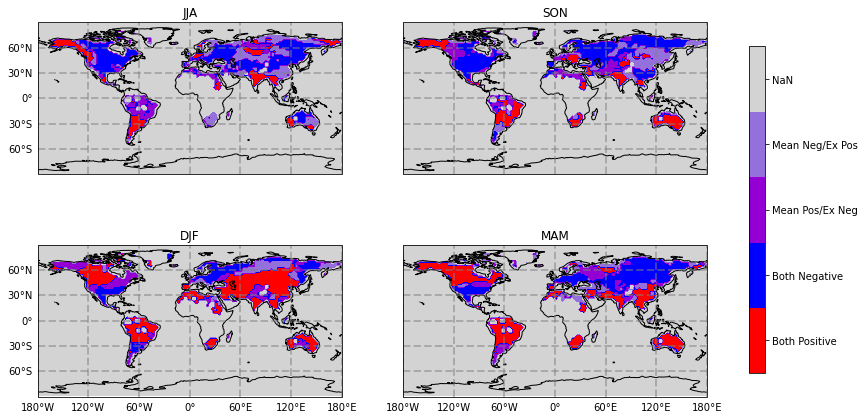

In [12]:
#Plot sign correlation between seasonal mean temperature and TXx 
fig = plt.figure(figsize=(15,7.5))
axs = []

ax = fig.add_subplot(221, projection=ccrs.PlateCarree())
C = plt.contourf(lons_t, lats_t, mean_temp_TXx_sign_comp_jja, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('JJA')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(222, projection=ccrs.PlateCarree())
C = plt.contourf(lons_t, lats_t, mean_temp_TXx_sign_comp_son, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('SON')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(223, projection=ccrs.PlateCarree())
C = plt.contourf(lons_t, lats_t, mean_temp_TXx_sign_comp_djf, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('DJF')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(224, projection=ccrs.PlateCarree())
C = plt.contourf(lons_t, lats_t, mean_temp_TXx_sign_comp_mam, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('MAM')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#colorbar
cbar = plt.colorbar(C, ax=axs, ticks=bounds, shrink=0.8)
cbar.ax.set_yticklabels(['Both Positive', 'Both Negative', 'Mean Pos/Ex Neg', 'Mean Neg/Ex Pos', 'NaN'])

#plt.savefig('sign_comparison_of_ENSO_composites_mean_temp_TXx.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

[Text(1, 0.0, 'Both Positive'),
 Text(1, 1.0, 'Both Negative'),
 Text(1, 2.0, 'Mean Pos/Ex Neg'),
 Text(1, 3.0, 'Mean Neg/Ex Pos'),
 Text(1, 4.0, 'NaN')]

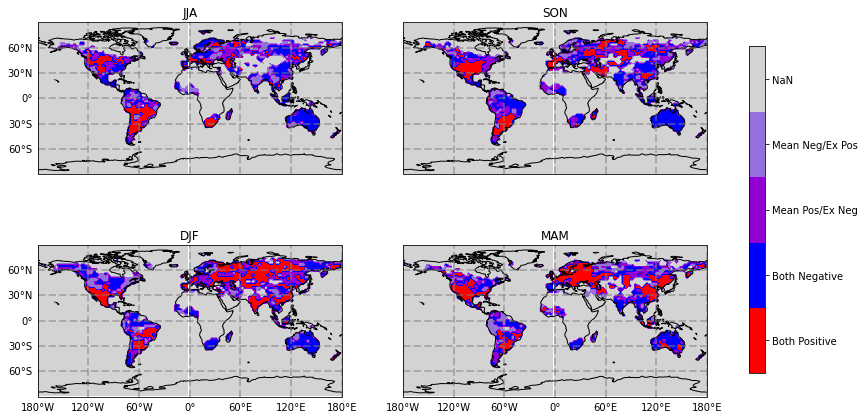

In [13]:
#Plot sign correlation between seasonal mean precipitation and Rx1day
fig = plt.figure(figsize=(15,7.5))
axs = []

ax = fig.add_subplot(221, projection=ccrs.PlateCarree())
C = plt.contourf(lons_p, lats_p, mean_precip_Rx1_sign_comp_jja, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('JJA')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(222, projection=ccrs.PlateCarree())
C = plt.contourf(lons_p, lats_p, mean_precip_Rx1_sign_comp_son, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('SON')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(223, projection=ccrs.PlateCarree())
C = plt.contourf(lons_p, lats_p, mean_precip_Rx1_sign_comp_djf, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('DJF')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(224, projection=ccrs.PlateCarree())
C = plt.contourf(lons_p, lats_p, mean_precip_Rx1_sign_comp_mam, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('MAM')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#colorbar
cbar = plt.colorbar(C, ax=axs, ticks=bounds, shrink=0.8)
cbar.ax.set_yticklabels(['Both Positive', 'Both Negative', 'Mean Pos/Ex Neg', 'Mean Neg/Ex Pos', 'NaN'])

#plt.savefig('sign_comparison_of_ENSO_composites_mean_precip_Rx1day.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### Calculate area percentages 

In [14]:
total_gridpoints_t = (np.shape(temp_data)[1]*np.shape(temp_data)[2])
total_land_gridpoints_t = total_gridpoints_t - temp_data.mean(dim='time').isnull().values.sum()
total_ocean_gridpoints_t = total_gridpoints_t - total_land_gridpoints_t

In [15]:
# Temperature and TXx
counts_temp_jja = [np.count_nonzero(mean_temp_TXx_sign_comp_jja == 0), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_jja == 1), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_jja == 2), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_jja == 3), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_jja == 4)-total_ocean_gridpoints_t]

counts_temp_son = [np.count_nonzero(mean_temp_TXx_sign_comp_son == 0), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_son == 1), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_son == 2), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_son == 3), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_son == 4)-total_ocean_gridpoints_t]

counts_temp_djf = [np.count_nonzero(mean_temp_TXx_sign_comp_djf == 0), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_djf == 1), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_djf == 2), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_djf == 3), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_djf == 4)-total_ocean_gridpoints_t]

counts_temp_mam = [np.count_nonzero(mean_temp_TXx_sign_comp_mam == 0), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_mam == 1), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_mam == 2), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_mam == 3), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_mam == 4)-total_ocean_gridpoints_t]

In [16]:
percent_temp_jja = np.around((counts_temp_jja/total_land_gridpoints_t)*100, 1)
percent_temp_son = np.around((counts_temp_son/total_land_gridpoints_t)*100, 1)
percent_temp_djf = np.around((counts_temp_djf/total_land_gridpoints_t)*100, 1)
percent_temp_mam = np.around((counts_temp_mam/total_land_gridpoints_t)*100, 1)

In [17]:
total_gridpoints_p = (np.shape(precip)[1]*np.shape(precip)[2])
total_land_gridpoints_p = total_gridpoints_p - precip.mean(dim='time').isnull().values.sum()
total_ocean_gridpoints_p = total_gridpoints_p - total_land_gridpoints_p

In [18]:
# Precipitation and Rx1day
counts_precip_jja = [np.count_nonzero(mean_precip_Rx1_sign_comp_jja == 0), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_jja == 1), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_jja == 2), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_jja == 3), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_jja == 4)-total_ocean_gridpoints_p]

counts_precip_son = [np.count_nonzero(mean_precip_Rx1_sign_comp_son == 0), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_son == 1), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_son == 2), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_son == 3), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_son == 4)-total_ocean_gridpoints_p]

counts_precip_djf = [np.count_nonzero(mean_precip_Rx1_sign_comp_djf == 0), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_djf == 1), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_djf == 2), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_djf == 3), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_djf == 4)-total_ocean_gridpoints_p]

counts_precip_mam = [np.count_nonzero(mean_precip_Rx1_sign_comp_mam == 0), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_mam == 1), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_mam == 2), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_mam == 3), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_mam == 4)-total_ocean_gridpoints_p]

In [19]:
percent_precip_jja = np.around((counts_precip_jja/total_land_gridpoints_p)*100, 1)
percent_precip_son = np.around((counts_precip_son/total_land_gridpoints_p)*100, 1)
percent_precip_djf = np.around((counts_precip_djf/total_land_gridpoints_p)*100, 1)
percent_precip_mam = np.around((counts_precip_mam/total_land_gridpoints_p)*100, 1)

In [20]:
# Make a table 
cols = ['Both Positive', 'Both Negative', 'Mean Pos/Ex Neg', 'Mean Neg/Ex Pos', 'NaN'] 
rows = ['JJA', 'SON', 'DJF', 'MAM']
cells_temp = [percent_temp_jja, percent_temp_son, percent_temp_djf, percent_temp_mam]
cells_precip = [percent_precip_jja, percent_precip_son, percent_precip_djf, percent_precip_mam]

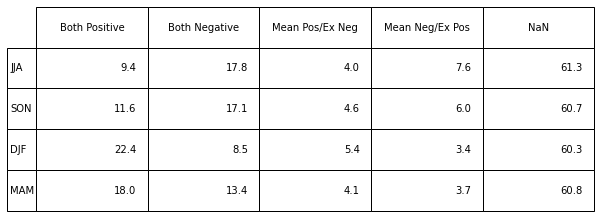

In [21]:
fig, ax = plt.subplots(1, figsize=(10,2.5))
ax.axis('off')
tab = ax.table(cellText=cells_temp, rowLabels=rows, colLabels=cols, bbox=[0,-0.1,1,1.5])
tab.set_fontsize(14)

#plt.savefig('area_percentages_mean_temp_TXx.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

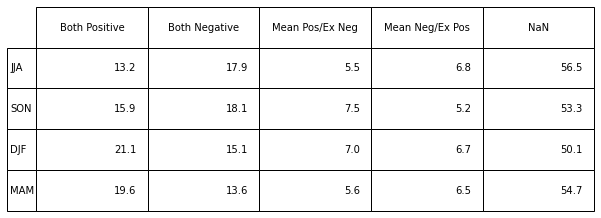

In [22]:
fig, ax = plt.subplots(1, figsize=(10,2.5))
ax.axis('off')
tab = ax.table(cellText=cells_precip, rowLabels=rows, colLabels=cols, bbox=[0,-0.1,1,1.5])
tab.set_fontsize(14)

#plt.savefig('area_percentages_mean_precip_Rx1day.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### Repeat above but with more significance
Only colour if greater than one standard deviation

In [38]:
#Sign comparison between mean temp and TXx with threshold (1 standard deviation)
mean_temp_TXx_sign_comp_with_threshold_jja = func.sign_corr_with_threshold(seasonal_temp_jja_diff, seasonal_TXx_jja_diff, seasonal_temp_jja.sel(seasonyear=slice(1950,1979)), seasonal_TXx_jja.sel(time=slice(1950, 1979)), 0.5)
mean_temp_TXx_sign_comp_with_threshold_son = func.sign_corr_with_threshold(seasonal_temp_son_diff, seasonal_TXx_son_diff, seasonal_temp_son.sel(seasonyear=slice(1950,1979)), seasonal_TXx_son.sel(time=slice(1950, 1979)), 0.5)
mean_temp_TXx_sign_comp_with_threshold_djf = func.sign_corr_with_threshold(seasonal_temp_djf_diff, seasonal_TXx_djf_diff, seasonal_temp_djf.sel(seasonyear=slice(1950,1979)), seasonal_TXx_djf.sel(time=slice(1950, 1979)), 0.5)
mean_temp_TXx_sign_comp_with_threshold_mam = func.sign_corr_with_threshold(seasonal_temp_mam_diff, seasonal_TXx_mam_diff, seasonal_temp_mam.sel(seasonyear=slice(1950,1979)), seasonal_TXx_mam.sel(time=slice(1950, 1979)), 0.5)

In [39]:
#Sign comparison between mean precip and Rx1day with threshold (1 standard deviation)
mean_precip_Rx1_sign_comp_with_threshold_jja = func.sign_corr_with_threshold(seasonal_precip_jja_diff, seasonal_Rx1_jja_diff, seasonal_precip_jja.sel(seasonyear=slice(1950,1979)), seasonal_Rx1_jja.sel(time=slice(1950, 1979)), 0.5)
mean_precip_Rx1_sign_comp_with_threshold_son = func.sign_corr_with_threshold(seasonal_precip_son_diff, seasonal_Rx1_son_diff, seasonal_precip_son.sel(seasonyear=slice(1950,1979)), seasonal_Rx1_son.sel(time=slice(1950, 1979)), 0.5)
mean_precip_Rx1_sign_comp_with_threshold_djf = func.sign_corr_with_threshold(seasonal_precip_djf_diff, seasonal_Rx1_djf_diff, seasonal_precip_djf.sel(seasonyear=slice(1950,1979)), seasonal_Rx1_djf.sel(time=slice(1950, 1979)), 0.5)
mean_precip_Rx1_sign_comp_with_threshold_mam = func.sign_corr_with_threshold(seasonal_precip_mam_diff, seasonal_Rx1_mam_diff, seasonal_precip_mam.sel(seasonyear=slice(1950,1979)), seasonal_Rx1_mam.sel(time=slice(1950, 1979)), 0.5)

<ipython-input-42-e64761c1bd8c>:69: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('sign_comparison_of_ENSO_composites_0.5std_mean_temp_TXx.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
<ipython-input-42-e64761c1bd8c>:69: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig('sign_comparison_of_ENSO_composites_0.5std_mean_temp_TXx.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
<ipython-input-42-e64761c1bd8c>:69: MatplotlibDeprecationWarning:

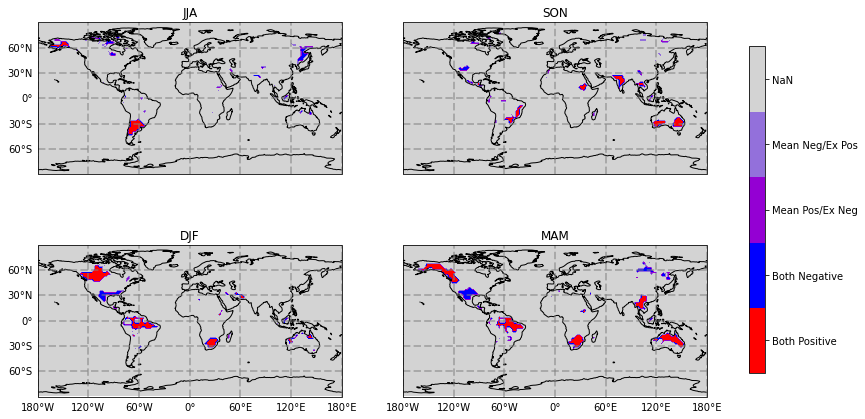

In [42]:
#Plot sign correlation between seasonal mean temperature and TXx 
fig = plt.figure(figsize=(15,7.5))
axs = []

ax = fig.add_subplot(221, projection=ccrs.PlateCarree())
C = plt.contourf(lons_t, lats_t, mean_temp_TXx_sign_comp_with_threshold_jja, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('JJA')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(222, projection=ccrs.PlateCarree())
C = plt.contourf(lons_t, lats_t, mean_temp_TXx_sign_comp_with_threshold_son, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('SON')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(223, projection=ccrs.PlateCarree())
C = plt.contourf(lons_t, lats_t, mean_temp_TXx_sign_comp_with_threshold_djf, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('DJF')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(224, projection=ccrs.PlateCarree())
C = plt.contourf(lons_t, lats_t, mean_temp_TXx_sign_comp_with_threshold_mam, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('MAM')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#colorbar
cbar = plt.colorbar(C, ax=axs, ticks=bounds, shrink=0.8)
cbar.ax.set_yticklabels(['Both Positive', 'Both Negative', 'Mean Pos/Ex Neg', 'Mean Neg/Ex Pos', 'NaN'])

#plt.savefig('sign_comparison_of_ENSO_composites_0.5std_mean_temp_TXx.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

<ipython-input-43-9cc1a323353c>:69: MatplotlibDeprecationWarning: 
The 'quality' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'quality': ...} instead. If any parameter follows 'quality', they should be passed as keyword, not positionally.
  plt.savefig('sign_comparison_of_ENSO_composites_0.5std_mean_precip_Rx1day.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
<ipython-input-43-9cc1a323353c>:69: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig('sign_comparison_of_ENSO_composites_0.5std_mean_precip_Rx1day.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)
<ipython-input-43-9cc1a323353c>:69: MatplotlibDeprecati

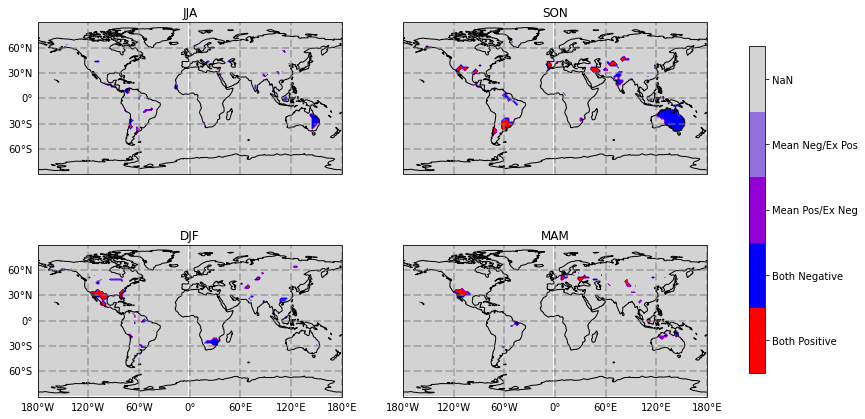

In [43]:
#Plot sign correlation between seasonal mean precipitation and Rx1day
fig = plt.figure(figsize=(15,7.5))
axs = []

ax = fig.add_subplot(221, projection=ccrs.PlateCarree())
C = plt.contourf(lons_p, lats_p, mean_precip_Rx1_sign_comp_with_threshold_jja, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('JJA')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabels_bottom = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(222, projection=ccrs.PlateCarree())
C = plt.contourf(lons_p, lats_p, mean_precip_Rx1_sign_comp_with_threshold_son, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('SON')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(223, projection=ccrs.PlateCarree())
C = plt.contourf(lons_p, lats_p, mean_precip_Rx1_sign_comp_with_threshold_djf, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('DJF')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax = fig.add_subplot(224, projection=ccrs.PlateCarree())
C = plt.contourf(lons_p, lats_p, mean_precip_Rx1_sign_comp_with_threshold_mam, add_colorbar=False, cmap=cmap, norm=norm, levels=bounds+0.5, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_global()
axs.append(ax)
ax.set_title('MAM')
#gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

#colorbar
cbar = plt.colorbar(C, ax=axs, ticks=bounds, shrink=0.8)
cbar.ax.set_yticklabels(['Both Positive', 'Both Negative', 'Mean Pos/Ex Neg', 'Mean Neg/Ex Pos', 'NaN'])

#plt.savefig('sign_comparison_of_ENSO_composites_0.5std_mean_precip_Rx1day.jpg', bbox_inches='tight', dpi=300, quality=80, optimize=True, progressive=True)

### Calculate area percentages 

In [27]:
# Temperature and TXx
counts_temp_jja_th = [np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_jja == 0), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_jja == 1), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_jja == 2), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_jja == 3), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_jja == 4)-total_ocean_gridpoints_t]

counts_temp_son_th = [np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_son == 0), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_son == 1), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_son == 2), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_son == 3), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_son == 4)-total_ocean_gridpoints_t]

counts_temp_djf_th = [np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_djf == 0), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_djf == 1), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_djf == 2), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_djf == 3), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_djf == 4)-total_ocean_gridpoints_t]

counts_temp_mam_th = [np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_mam == 0), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_mam == 1), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_mam == 2), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_mam == 3), 
                   np.count_nonzero(mean_temp_TXx_sign_comp_with_threshold_mam == 4)-total_ocean_gridpoints_t]

In [28]:
percent_temp_jja_th = np.around((counts_temp_jja_th/total_land_gridpoints_t)*100, 1)
percent_temp_son_th = np.around((counts_temp_son_th/total_land_gridpoints_t)*100, 1)
percent_temp_djf_th = np.around((counts_temp_djf_th/total_land_gridpoints_t)*100, 1)
percent_temp_mam_th = np.around((counts_temp_mam_th/total_land_gridpoints_t)*100, 1)

In [29]:
# Precipitation and Rx1day
counts_precip_jja_th = [np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_jja == 0), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_jja == 1), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_jja == 2), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_jja == 3), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_jja == 4)-total_ocean_gridpoints_p]

counts_precip_son_th = [np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_son == 0), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_son == 1), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_son == 2), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_son == 3), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_son == 4)-total_ocean_gridpoints_p]

counts_precip_djf_th = [np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_djf == 0), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_djf == 1), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_djf == 2), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_djf == 3), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_djf == 4)-total_ocean_gridpoints_p]

counts_precip_mam_th = [np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_mam == 0), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_mam == 1), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_mam == 2), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_mam == 3), 
                   np.count_nonzero(mean_precip_Rx1_sign_comp_with_threshold_mam == 4)-total_ocean_gridpoints_p]

In [30]:
percent_precip_jja_th = np.around((counts_precip_jja_th/total_land_gridpoints_p)*100, 1)
percent_precip_son_th = np.around((counts_precip_son_th/total_land_gridpoints_p)*100, 1)
percent_precip_djf_th = np.around((counts_precip_djf_th/total_land_gridpoints_p)*100, 1)
percent_precip_mam_th = np.around((counts_precip_mam_th/total_land_gridpoints_p)*100, 1)

In [31]:
# Make a table
cells_temp_th = [percent_temp_jja_th, percent_temp_son_th, percent_temp_djf_th, percent_temp_mam_th]
cells_precip_th = [percent_precip_jja_th, percent_precip_son_th, percent_precip_djf_th, percent_precip_mam_th]

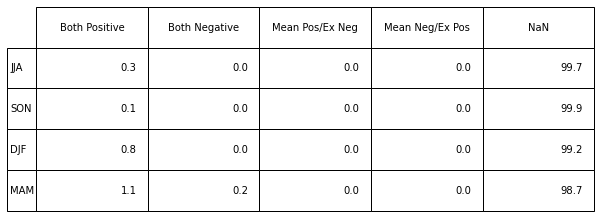

In [32]:
fig, ax = plt.subplots(1, figsize=(10,2.5))
ax.axis('off')
tab = ax.table(cellText=cells_temp_th, rowLabels=rows, colLabels=cols, bbox=[0,-0.1,1,1.5])
tab.set_fontsize(14)

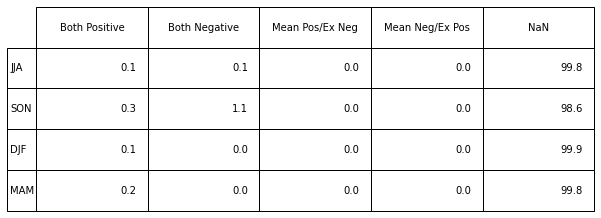

In [33]:
fig, ax = plt.subplots(1, figsize=(10,2.5))
ax.axis('off')
tab = ax.table(cellText=cells_precip_th, rowLabels=rows, colLabels=cols, bbox=[0,-0.1,1,1.5])
tab.set_fontsize(14)